<Body>   
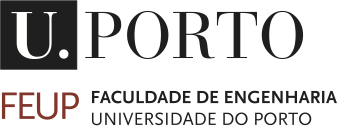   
<h1> <b>Computer Vision 2022/2023 </b> </h1>
<p><b>João Carlos N. Bittencourt </b> (joaocarlos@ufrb.edu.br)</p>
<p>PhD Student</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# A Remote Sensing Fire Risk Assessment Using Convolutional Neural Networks

## Introduction
This script is used to train a convolutional neural network (CNN) to predict fire risk from satellite images.



In [1]:
# include libraries
import sys
sys.path.append('./libs')
import torch
import libs.setup as su
import importlib


# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


## Dataset
The dataset is composed of 7 classes: very low, low, moderate, high, very high, non-burnable and water. The images are 320x320 pixels and are stored in the `FireRisk-Dataset` folder. The dataset is divided into training and test sets. The training set has 70331 images and the test set has 21541 images.

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
from libs.dataset import FireRiskDataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((299, 299)),  # Inception requires 299x299 input  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAdjustSharpness(2, 0.9),
    transforms.RandomVerticalFlip(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((299, 299)),  # Inception requires 299 input
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

classes = ["High", "Moderate", "Low", "Non-burnable", "Water"]

label_dict = {
    "High": 0,
    "Moderate": 1,
    "Low": 2,
    "Non-burnable": 3,
    "Water": 4,
}

# Setup training dataset and loader
train_dataset = FireRiskDataset(
    root_dir="./FireRisk-Dataset/FireRiskV2/train/", 
    transform=transform, 
    sample_size=round(su.train_samples), 
    label_dict=label_dict
)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=su.batch_size, 
    shuffle=True, 
    num_workers=su.num_workers
)

# Setup validation dataset and loader
val_dataset = FireRiskDataset(
    root_dir="./FireRisk-Dataset/FireRiskV2/val/",
    transform=val_transform,
    sample_size=su.sample_size,
    label_dict=label_dict,
)
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=su.batch_size, 
    shuffle=False, 
    num_workers=su.num_workers
)

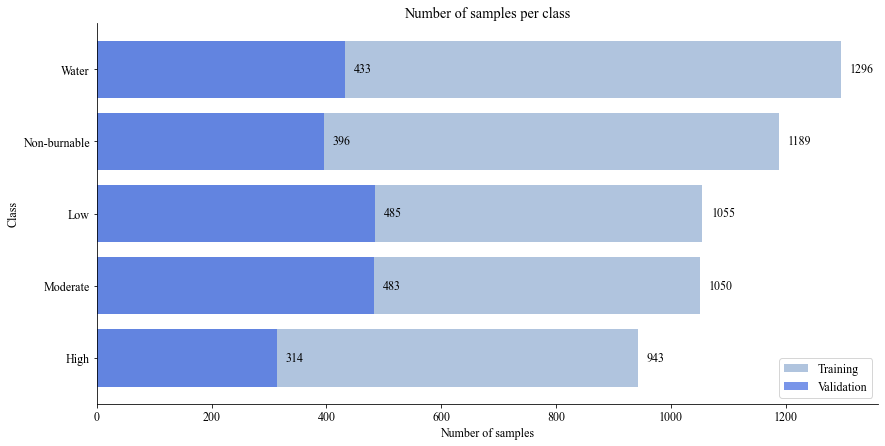

Training dataset size: 5533
Validations dataset size: 2111


<Figure size 432x288 with 0 Axes>

In [3]:
# Plot a graph with the number of samples per class
import matplotlib.pyplot as plt

# Set global font to Arial
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12  # You can also set the global font size here

plt.figure(figsize=(14, 7))

# Plot training data
train_counts = [train_dataset.labels.count(i) for i in range(len(classes))]
plt.barh(classes, train_counts, label="Training", color="lightsteelblue")

# Plot validation data
val_counts = [val_dataset.labels.count(i) for i in range(len(classes))]
plt.barh(classes, val_counts, label="Validation", alpha=0.7, color="royalblue")

# Labels and title
plt.xlabel("Number of samples")
plt.ylabel("Class")
plt.title("Number of samples per class")
plt.legend()

# Font sizes for ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Add total number of samples after the bar
margin = 15
for index, value in enumerate(train_counts):
    plt.text(
        value + margin,
        index,
        str(value),
        va="center",
        ha="left",
        fontsize=12,
        color="black",
    )
for index, value in enumerate(val_counts):
    plt.text(
        value + margin,
        index,
        str(value),
        va="center",
        ha="left",
        fontsize=12,
        color="black",
    )

plt.show()

plt.savefig("prometheus_dataset.png", dpi=300)

# Print dataset sizes
print("Training dataset size:", len(train_dataset))
print("Validations dataset size:", len(val_dataset))

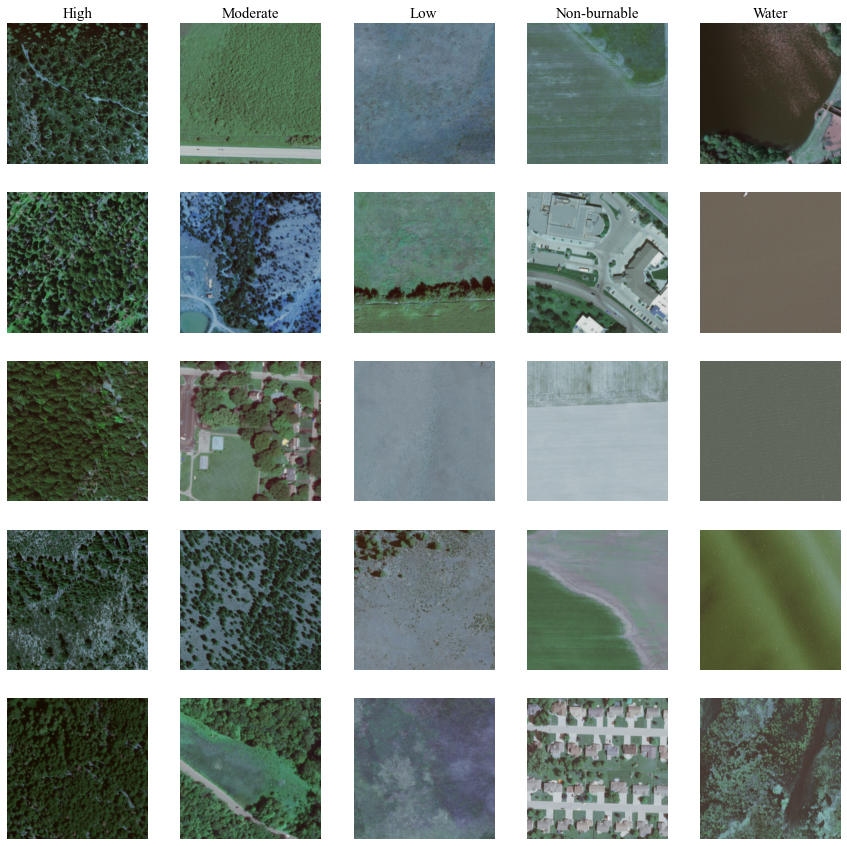

In [4]:
# Present 5 examples of images from the dataset for each class from the original folder (without transformations)
import random
import matplotlib.pyplot as plt
import os
from PIL import Image

# Set global font to Arial
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18  # You can also set the global font size here

# Create a figure with 5 columns and 5 rows
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Iterate over each class
for i, class_name in enumerate(classes):
    # Get the path of the class folder
    class_path = os.path.join("./FireRisk-Dataset/FireRiskV2/train/", class_name)
    # Get the list of images in the class folder
    images = os.listdir(class_path)
    # Randomly select 5 images
    selected_images = random.sample(images, 5)
    # Iterate over each image
    for j, image_name in enumerate(selected_images):
        # Get the image path
        image_path = os.path.join(class_path, image_name)  # Open the image
        image = Image.open(image_path)
        # Plot the image
        axs[j, i].imshow(image)
        # Remove the axes
        axs[j, i].axis("off")
    
    # Set the title of the column
    axs[0, i].set_title(class_name, fontsize=15)
    # Adjust bottom margin of the title
    axs[0, i].title.set_position([0.5, 2.1, 2])

plt.show() 

# Defining the CNN Model
The CNN model is defined using the timm library. For this experiment we will use the inception_resnet_v2 model with the following modifications:
- The output layer is modified to have 7 classes
- The model is trained using the Adam optimizer with a learning rate of 0.000125 
- The model is trained using the categorical crossentropy loss function


In [7]:
import timm
import torch.nn as nn

# Inception ResNet V2
inception = timm.create_model("inception_resnet_v2", pretrained=True, num_classes=len(classes))

# Define the loss function and optimizer considering different learning rates for different layers
# base_params = list(inception.conv2d_1a.parameters()) + list(
#     inception.conv2d_2a.parameters()
# )
# mid_params = list(inception.mixed_5b.parameters()) + list(inception.repeat.parameters())
# top_params = list(inception.classif.parameters())
# optimizer = torch.optim.NAdam(
#    [
#        {"params": base_params, "lr": su.base_learning_rate},
#        {"params": mid_params, "lr": su.base_learning_rate * 0.75},
#        {"params": top_params, "lr": su.base_learning_rate * 0.75**2},
#    ],
#    lr=su.learning_rate,
#    weight_decay=su.weight_decay,
# )

optimizer = torch.optim.SGD(inception.parameters(), lr=su.learning_rate, weight_decay=su.weight_decay)
criterion = nn.CrossEntropyLoss(label_smoothing=su.smoothing_factor).to(device)

In [8]:
# Freeze all parameters initially
for param in inception.parameters():
    param.requires_grad = False

# Unfreeze specific blocks/layers
# Example: Unfreezing repeat_2 and all subsequent layers
layers_to_unfreeze = ["mixed_7a", "conv2d_7b", "classif"]
for name, child in inception.named_children():
    if name in layers_to_unfreeze:
        for param in child.parameters():
            param.requires_grad = True

## Training the Model

In [9]:
import libs.model_utils as mu

if __name__ == "__main__":

    # Build our model
    (
        best_loss,
        best_accuracy,
        best_epoch,
        train_acc_list,
        train_loss_list,
        val_acc_list,
        val_loss_list,
    ) = mu.train_and_eval(
        model=inception,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        device=device,
        start_epoch=0,
        num_epochs=su.num_epochs,
        early_stop=True,
        patience=su.patience,
        path_model=str("./models/InceptionResnetV2/Prometheus_InceptionResnetV2_"),
        verbatim=True,
    )
    print('Finished Training')

/home/joaocarlos/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1 / 80]: Train Loss=1.5940733875842452, Train Accu=0.23471542907959095, Validation Loss=1.5873645327307961, Validation Accu=0.24573863636363635
Validation loss decreased (inf --> 1.587365).  Saving model ...
Epoch [2 / 80]: Train Loss=1.5722821137808651, Train Accu=0.29075422409959983, Validation Loss=1.5681475428017704, Validation Accu=0.3111111111111111
Validation loss decreased (1.587365 --> 1.568148).  Saving model ...
Epoch [3 / 80]: Train Loss=1.5520083652755428, Train Accu=0.3779596487327701, Validation Loss=1.5552900496757391, Validation Accu=0.3433396464646465
Validation loss decreased (1.568148 --> 1.555290).  Saving model ...
Epoch [4 / 80]: Train Loss=1.533851016463572, Train Accu=0.4401400622498889, Validation Loss=1.5359765869198423, Validation Accu=0.3925820707070707
Validation loss decreased (1.555290 --> 1.535977).  Saving model ...
Epoch [5 / 80]: Train Loss=1.519815655457491, Train Accu=0.46326144953312587, Validation Loss=1.524081031481425, Validation Accu=0.

Best loss: 1.1191403224612728
Best accuracy: 0.6589962121212121
Best epoch: 80


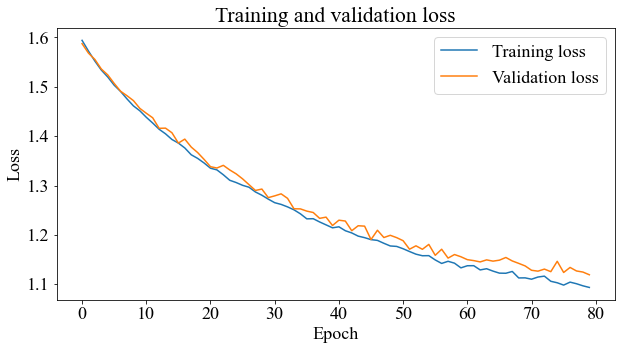

In [11]:
# Display the best results
print("Best loss:", best_loss)
print("Best accuracy:", best_accuracy)
print("Best epoch:", best_epoch+1)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label="Training loss")
plt.plot(val_loss_list, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
# Load the best model
import libs.model_utils as mu

# Load the model we just created
inception = inception.to(device)

# Get best model path
best_model_path = (
    "./models/InceptionResnetV2/Prometheus_InceptionResnetV2_checkpoint.pth"
)

inception.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

# Model Evaluation

In [13]:
true_labels, predicted_labels = mu.evaluate_model(inception, val_loader, device, criterion)

Accuracy on validation set: 65.89294173377546%


In [14]:
# Implement precision, recall and F1-score assessment
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels, target_names=classes))


              precision    recall  f1-score   support

        High       0.63      0.61      0.62       314
    Moderate       0.57      0.49      0.53       483
         Low       0.64      0.60      0.62       485
Non-burnable       0.62      0.76      0.68       396
       Water       0.82      0.85      0.84       433

    accuracy                           0.66      2111
   macro avg       0.66      0.66      0.66      2111
weighted avg       0.66      0.66      0.66      2111



Predicted class: High
File name: 32077981_3_-109.814010623843_42.9701133158106.png


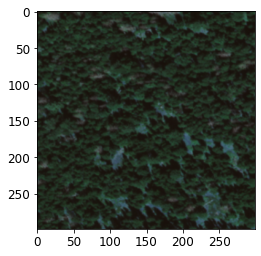

In [30]:
mu.predict_image_class(class_name="Moderate", dataset=val_dataset, model=inception, device=device, transform=transform, classes=classes)

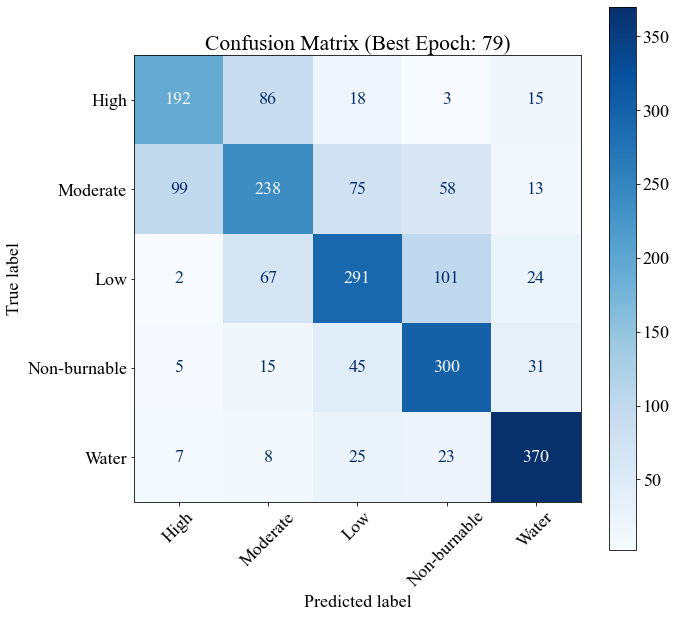

In [15]:
from importlib import reload
import libs.model_utils as mu
reload(mu)
mu.plot_confusion_matrix(true_labels, predicted_labels, classes, best_epoch)